# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy  : 1.19.4
openpiv: 0.23.3b0

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
from openpiv import windef

import numpy as np
import os
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)


In [3]:
settings = windef.Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../test9/'
# Folder for the outputs
settings.save_path = '../test9/results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'
# settings.ROI = (200,400,500,900)

# settings.deformation_method = 'symmetric' 
settings.deformation_method = 'second image'


settings.num_iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 6)
settings.overlap=(32, 16, 8, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)

# 'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_threshold = 1.25
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
settings.sig2noise_validate = False

# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 100  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation = False

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'


settings.replace_vectors = True
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4
settings.filter_kernel_size = 2  # kernel size for the localmean method



settings.MinMax_U_disp = (-10, 10)
settings.MinMax_V_disp = (-10, 10)

# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size = 2 # defines the size of the local median, it'll be 3 x 3

# New settings for version 0.23.2c
settings.image_mask = False

# Image mask properties
settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21



# Smoothing after the first pass
settings.smoothn = False #Enables smoothing of the displacemenet field
settings.smoothn_p = 0.5 # This is a smoothing parameter


settings.show_all_plots = False

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
global filter invalidated 0 vectors
std filter invalidated 0 vectors
median filter invalidated 0 vectors
global filter invalidated 0 vectors
median filter invalidated 2 vectors
global filter invalidated 0 vectors
median filter invalidated 16 vectors
global filter invalidated 0 vectors
median filter invalidated 3 vectors


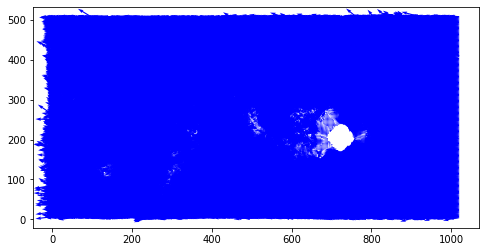

Image Pair 1


In [4]:
%time
windef.piv(settings)

In [5]:
from pivpy import pivpy, io, graphics
import xarray as xr

In [6]:
import glob

file_list = sorted(glob.glob('../test9/results/Open_PIV_results_'+str(settings.windowsizes[settings.num_iterations-1])+'_Test_1/*.txt'))
file_list

['../test9/results/Open_PIV_results_6_Test_1/field_A000.txt']

In [7]:
data = []
frame = 0
for f in file_list:
    data.append(io.load_txt(f,frame=frame))
    frame += 1
    
data = xr.concat(data,dim='t')
data.attrs['units']= ['pix','pix','pix/dt','pix/dt']
# file_list = sorted(glob.glob('../OpenPIV_results/Open_PIV_results_6_Test_1/*.txt'))

In [8]:
data.piv.vorticity();

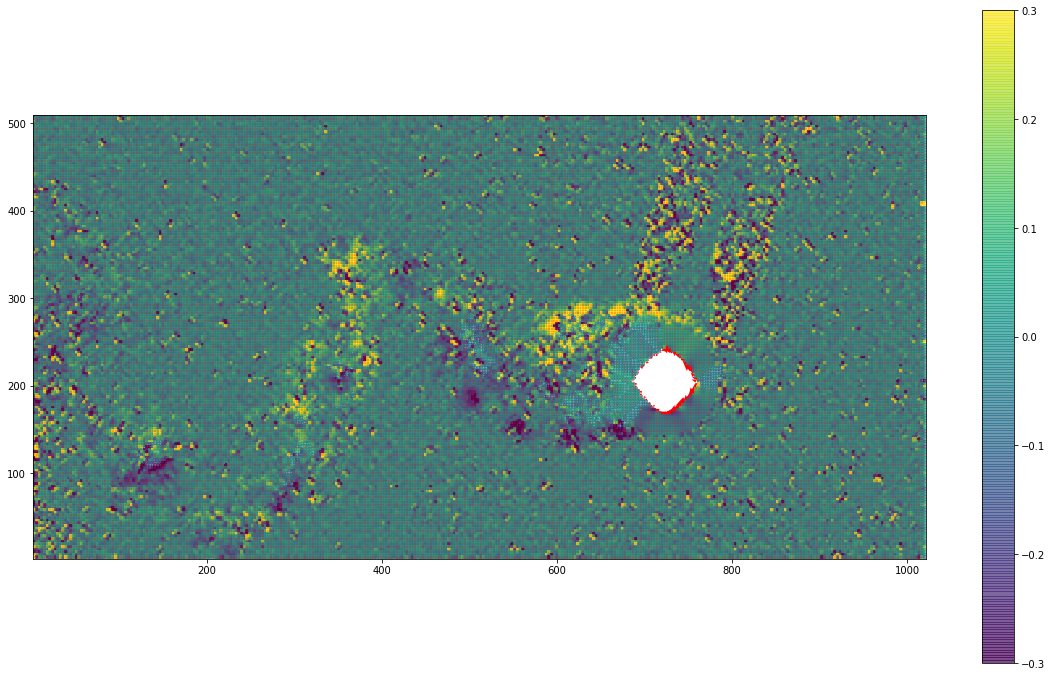

In [9]:
import matplotlib.pyplot as plt
def plot_data(data):
    fig, ax = plt.subplots(1,1,figsize=(20,12))
    # for ax in axs:
    ax.quiver(data.x.data, data.y.data, data.u.isel(t=0).data.T, data.v.isel(t=0).data.T, color='r', scale=120)
    s = ax.pcolor(data.x,data.y,data.w.T.isel(t=0), shading='interp', vmin=-.3, vmax=.3,alpha=0.7)
    ax.set_aspect(1)
    fig.colorbar(s, ax=ax,)
    plt.show()
    
plot_data(data)

In [10]:
import openpiv.original_windef as original_windef

In [11]:
# %pdb

newsettings = original_windef.Settings()
for att in newsettings.__dict__:
    if hasattr(settings, att):
        setattr(newsettings,att,getattr(settings,att))



newsettings.do_sig2noise_validation = settings.sig2noise_validate
newsettings.extract_sig2noise = settings.sig2noise_validate
newsettings.save_folder_suffix = 'Test_2'
newsettings.normalized_correlation=False
# newsettings.num_iterations = settings.num_iterations

# settings.correlation_method='linear'
# settings.show_all_plots = True

attrs = vars(newsettings)
[item for item in attrs.items()]

[('filepath_images', '../test9/'),
 ('save_path', '../test9/results/'),
 ('save_folder_suffix', 'Test_2'),
 ('frame_pattern_a', 'karman_16Hz_000_A.jpg'),
 ('frame_pattern_b', 'karman_16Hz_000_B.jpg'),
 ('ROI', 'full'),
 ('dynamic_masking_method', 'intensity'),
 ('dynamic_masking_threshold', 0.1),
 ('dynamic_masking_filter_size', 21),
 ('correlation_method', 'circular'),
 ('num_iterations', 4),
 ('windowsizes', (64, 32, 16, 6)),
 ('overlap', (32, 16, 8, 3)),
 ('subpixel_method', 'gaussian'),
 ('interpolation_order', 3),
 ('scaling_factor', 1),
 ('dt', 1),
 ('extract_sig2noise', False),
 ('sig2noise_method', None),
 ('sig2noise_mask', 2),
 ('validation_first_pass', True),
 ('MinMax_U_disp', (-10, 10)),
 ('MinMax_V_disp', (-10, 10)),
 ('std_threshold', 5),
 ('median_threshold', 3),
 ('median_size', 2),
 ('do_sig2noise_validation', False),
 ('sig2noise_threshold', 1.25),
 ('replace_vectors', True),
 ('smoothn', False),
 ('smoothn_p', 0.5),
 ('filter_method', 'localmean'),
 ('max_filter_ite

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
global filter invalidated 0 vectors
std filter invalidated 0 vectors
median filter invalidated 0 vectors


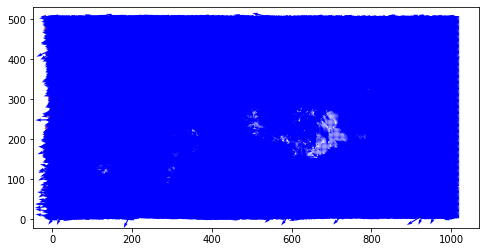

Image Pair 1


In [12]:
%time
original_windef.piv(newsettings)

In [13]:
file_list = sorted(glob.glob('../test9/results/Open_PIV_results_'+str(newsettings.windowsizes[newsettings.num_iterations-1])+'_Test_2/*.txt'))
file_list

['../test9/results/Open_PIV_results_6_Test_2/field_A000.txt']

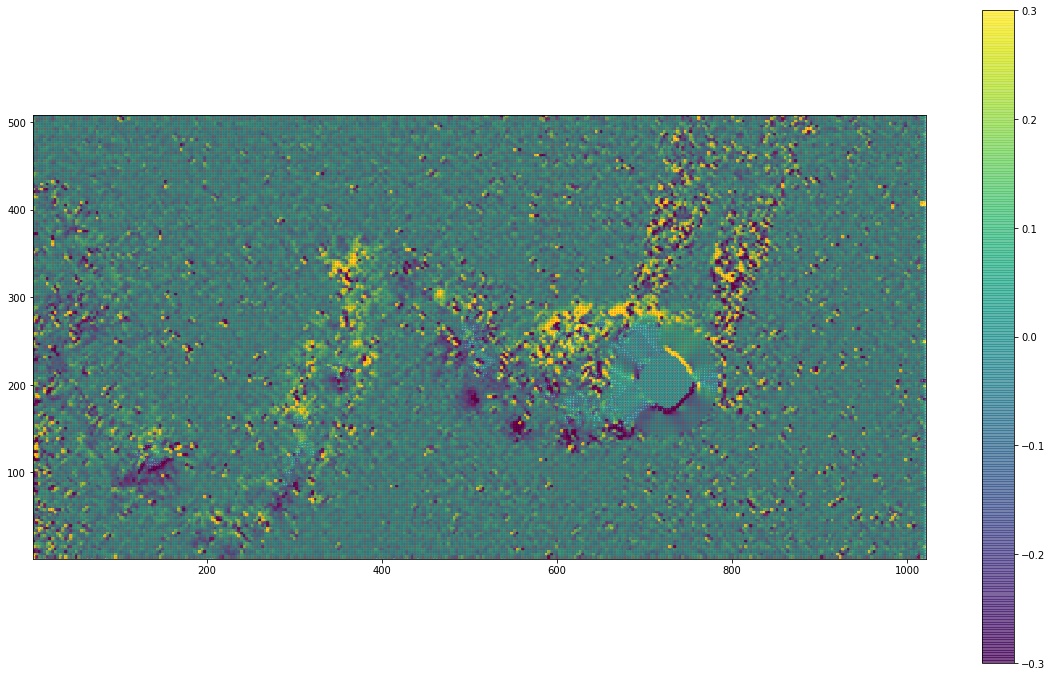

In [14]:
data = []
frame = 0
for f in file_list:
    data.append(io.load_txt(f,frame=frame))
    frame += 1
    
data = xr.concat(data,dim='t')
data.attrs['units']= ['pix','pix','pix/dt','pix/dt']
data.piv.vorticity();

plot_data(data)